#### MultiLabel Classification with multiple targets... 

Target 1 = q58: Ever had sex<br>
Target 2 = q25: Sad or Hopeless<br>
Target 3 = q30: Ever tried cigarettes<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format ='retina'

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection 
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, hamming_loss
from skmultilearn.adapt import MLkNN, BRkNNaClassifier, BRkNNbClassifier, MLTSVM
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.ensemble import MajorityVotingClassifier

from scipy.sparse import csr_matrix, lil_matrix
from sklearn.pipeline import Pipeline

In [2]:
colors = ['#b166eb', '#8858D4', '#664CC1', '#4B43B2', '#072B8B']
sns.set_palette(colors)


In [34]:
df = pd.read_csv('data/SADCQ.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504249 entries, 0 to 504248
Columns: 151 entries, sitecode to qtransgender
dtypes: float64(142), int64(6), object(3)
memory usage: 580.9+ MB


In [5]:
# Make record # the index

df.set_index('record', inplace=True)

In [7]:
cols = df.columns.tolist()
cols

['sitecode',
 'sitename',
 'sitetype',
 'sitetypenum',
 'year',
 'survyear',
 'weight',
 'stratum',
 'PSU',
 'age',
 'sex',
 'grade',
 'race4',
 'race7',
 'stheight',
 'stweight',
 'bmi',
 'bmipct',
 'qnobese',
 'qnowt',
 'q66',
 'q65',
 'sexid',
 'sexid2',
 'sexpart',
 'sexpart2',
 'q8',
 'q9',
 'q10',
 'q11',
 'q12',
 'q13',
 'q14',
 'q15',
 'q16',
 'q17',
 'q18',
 'q19',
 'q20',
 'q21',
 'q22',
 'q23',
 'q24',
 'q25',
 'q26',
 'q27',
 'q28',
 'q29',
 'q30',
 'q31',
 'q32',
 'q33',
 'q34',
 'q35',
 'q36',
 'q37',
 'q38',
 'q39',
 'q40',
 'q41',
 'q42',
 'q43',
 'q44',
 'q45',
 'q46',
 'q47',
 'q48',
 'q49',
 'q50',
 'q51',
 'q52',
 'q53',
 'q54',
 'q55',
 'q56',
 'q57',
 'q58',
 'q59',
 'q60',
 'q61',
 'q62',
 'q63',
 'q64',
 'q67',
 'q68',
 'q69',
 'q70',
 'q71',
 'q72',
 'q73',
 'q74',
 'q75',
 'q76',
 'q77',
 'q78',
 'q79',
 'q80',
 'q81',
 'q82',
 'q83',
 'q84',
 'q85',
 'q86',
 'q87',
 'q88',
 'q89',
 'qbikehelmet',
 'qdrivemarijuana',
 'qcelldriving',
 'qpropertydamage',
 'qbul

In [36]:
to_drop = ['sitecode',
 'sitetype',
 'sitetypenum',
 'survyear',
 'weight',
 'stratum',
 'PSU',
 'race4',
 'stheight',
 'stweight',
 'bmipct',
 'qnobese',
 'qnowt',
 'q66',
 'q65',
 'sexid',
 'sexpart',
 'sexpart2',
 'q8',
 'q9',
 'q10',
 'q11',
 'q12',
 'q13',
 'q14',
 'q15',
 'q16',
 'q17',
 'q18',
 'q19',
 'q20',
 'q21',
 'q22',
 'q23',
 'q24',
 'q26',
 'q27',
 'q28',
 'q29',
 'q31',
 'q32',
 'q33',
 'q34',
 'q35',
 'q36',
 'q37',
 'q38',
 'q39',
 'q40',
 'q41',
 'q42',
 'q43',
 'q44',
 'q45',
 'q46',
 'q47',
 'q48',
 'q49',
 'q50',
 'q51',
 'q52',
 'q53',
 'q54',
 'q55',
 'q56',
 'q57',
 'q59',
 'q60',
 'q61',
 'q62',
 'q63',
 'q64',
 'q67',
 'q68',
 'q69',
 'q70',
 'q71',
 'q72',
 'q73',
 'q74',
 'q75',
 'q76',
 'q77',
 'q78',
 'q79',
 'q80',
 'q81',
 'q82',
 'q83',
 'q84',
 'q85',
 'q86',
 'q87',
 'q88',
 'q89',
 'qbikehelmet',
 'qdrivemarijuana',
 'qcelldriving',
 'qpropertydamage',
 'qbullyweight',
 'qbullygender',
 'qbullygay',
 'qchokeself',
 'qcigschool',
 'qchewtobschool',
 'qalcoholschool',
 'qtypealcohol2',
 'qhowmarijuana',
 'qmarijuanaschool',
 'qcurrentopioid',
 'qcurrentcocaine',
 'qcurrentheroin',
 'qcurrentmeth',
 'qhallucdrug',
 'qprescription30d',
 'qgenderexp',
 'qtaughtHIV',
 'qtaughtsexed',
 'qtaughtstd',
 'qtaughtcondom',
 'qtaughtbc',
 'qdietpop',
 'qcoffeetea',
 'qsportsdrink',
 'qenergydrink',
 'qsugardrink',
 'qwater',
 'qfastfood',
 'qfoodallergy',
 'qwenthungry',
 'qmusclestrength',
 'qsunscreenuse',
 'qindoortanning',
 'qsunburn',
 'qconcentrating',
 'qcurrentasthma',
 'qwheresleep',
 'qspeakenglish',
 'qtransgender']

In [37]:
df.drop(columns=to_drop, inplace=True)

In [38]:
# Just keep 2009 - 2019

df = df[df['year']>=2009]

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296030 entries, 208219 to 504248
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sitename  296030 non-null  object 
 1   year      296030 non-null  int64  
 2   record    296030 non-null  int64  
 3   age       295009 non-null  float64
 4   sex       293575 non-null  float64
 5   grade     291733 non-null  float64
 6   race7     284810 non-null  float64
 7   bmi       266288 non-null  float64
 8   sexid2    239957 non-null  float64
 9   q25       288586 non-null  float64
 10  q30       239885 non-null  float64
 11  q58       235980 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 29.4+ MB


In [40]:
sexid2_dict = {1: 'Heterosexual', 2: 'Sexual Minority', 3: 'Unsure'}

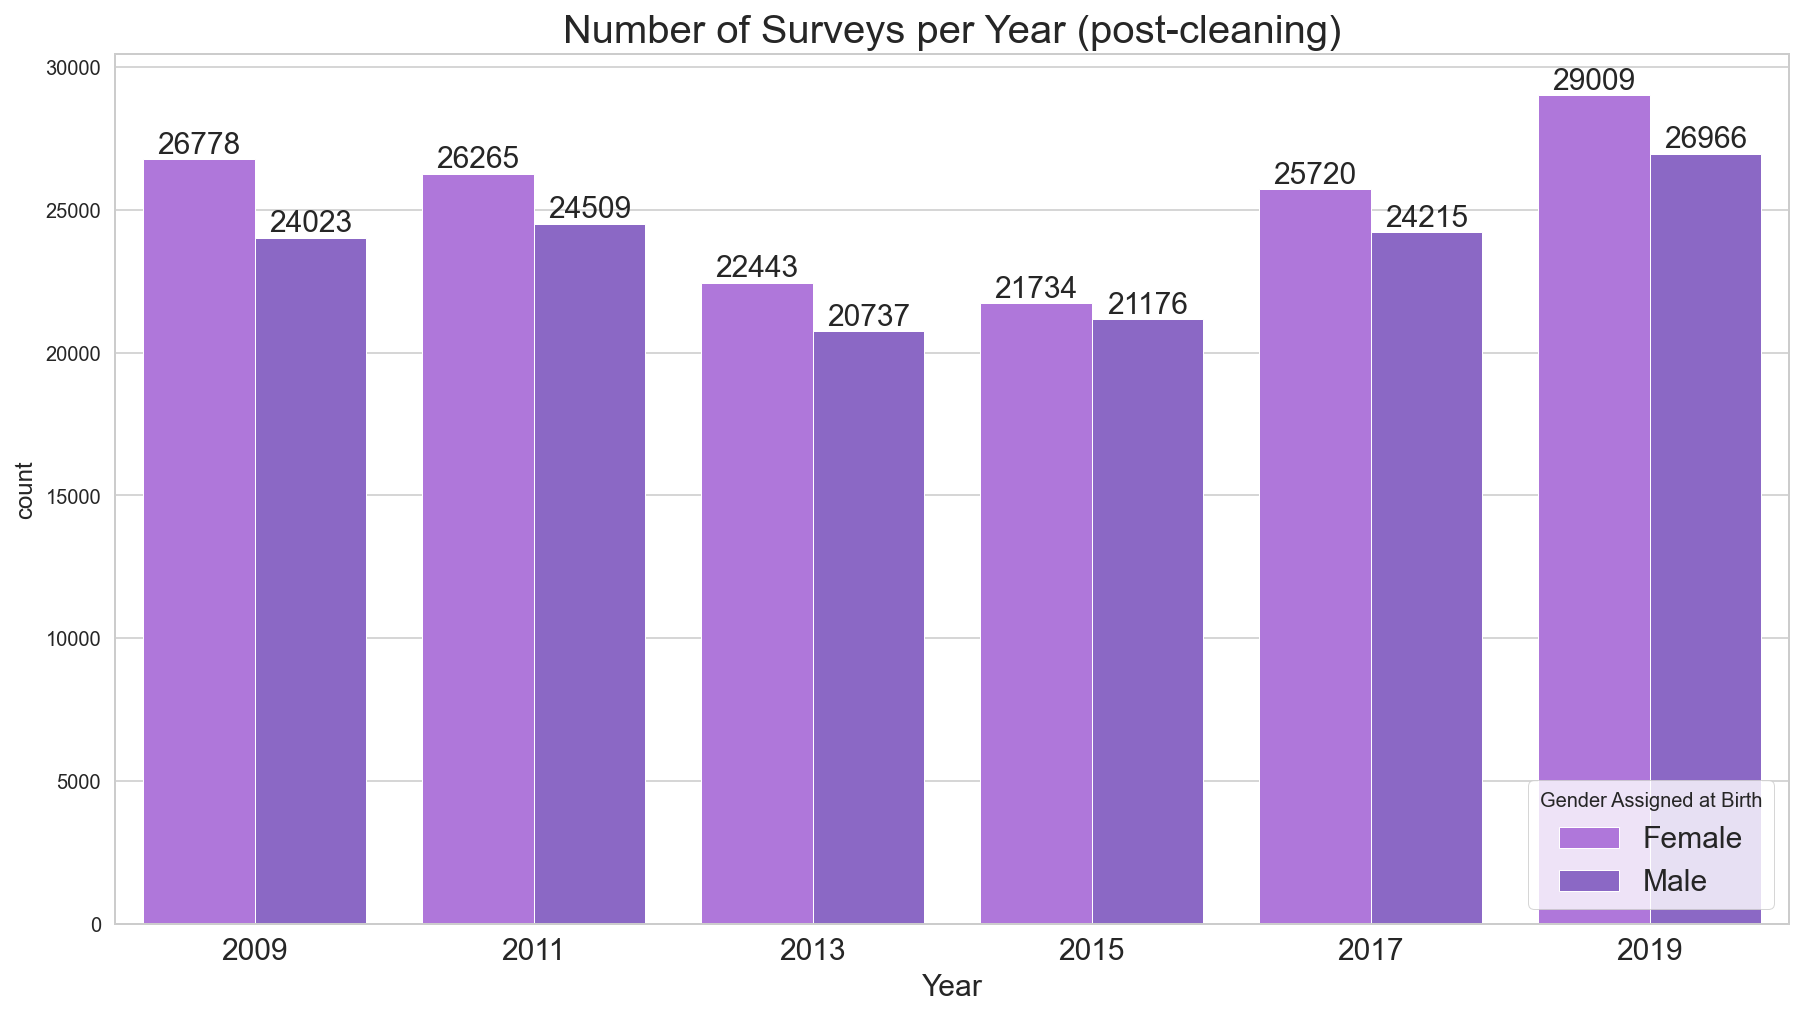

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df, x='year', hue='sex', palette=colors, ax=ax)

ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=15, fmt='%d')

ax.set_title('Number of Surveys per Year (post-cleaning)', fontsize=20)
ax.set_xticklabels(labels=[2009, 2011, 2013, 2015, 2017, 2019], fontsize=15)
ax.set_xlabel('Year', fontsize=15)
ax.legend(title='Gender Assigned at Birth', labels=['Female', 'Male'], loc='lower right', fontsize=15);


In [42]:
age_dict = {1: '12 yrs -', 2: '13 yrs', 3: '14 yrs', 
           4: '15 yrs', 5: '16 yrs', 6: '17 yrs', 7: '18 yrs +'}
age_labels = [v for k, v in age_dict.items()]

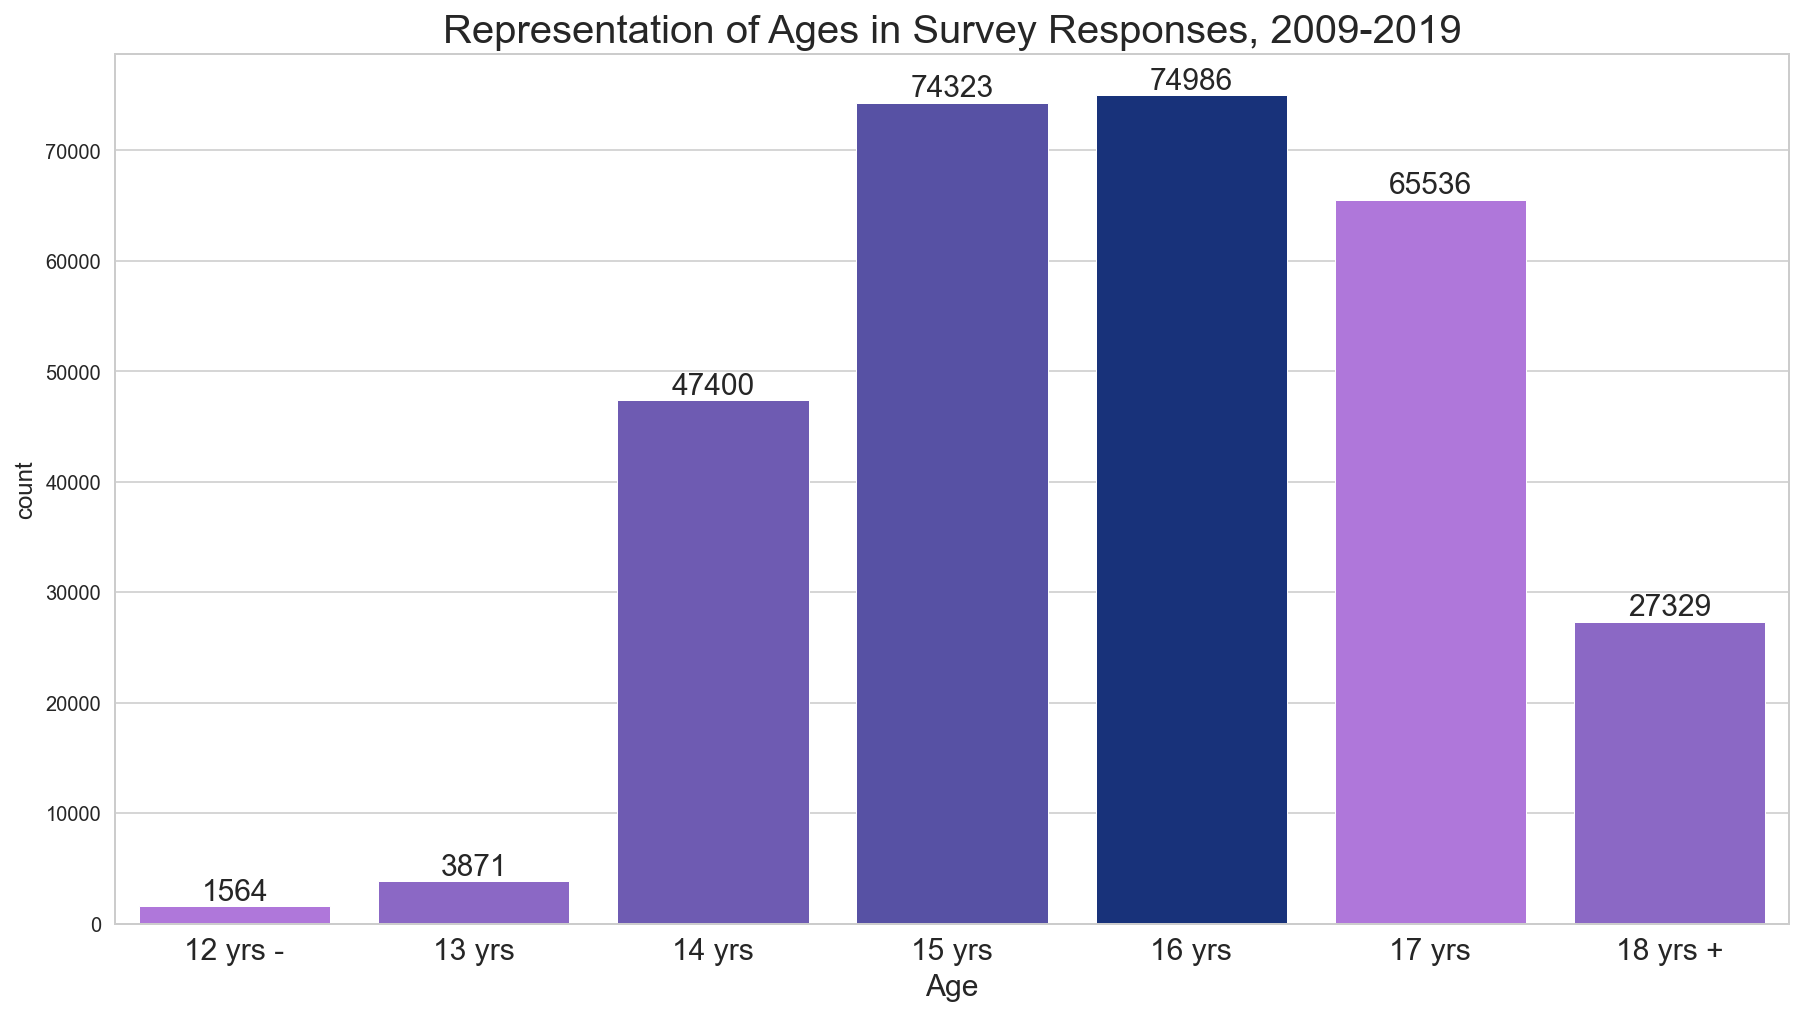

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df, x='age', palette=colors, ax=ax)
ax.set_xticklabels(labels=age_labels, fontsize=15)
ax.set_title('Representation of Ages in Survey Responses, 2009-2019', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.set_xlabel('Age', fontsize=15);

In [44]:
race7_dict = {1: 'AmInd/AlaskaNat', 2: 'Asian', 3: 'Black or Af Am', 
             4: 'Hisp/Latinx', 5: 'NatHaw/OtherPacIsl', 6: 'White', 7: 'Multiple Races (Non-Hisp)'}
race7_labels = ['Hisp/Latinx', 'Black or Af Am', 
               'White', 'Asian', 'Multiple Races', 
               'NatHaw/OtherPacIsl', 'AmInd/AlaskaNat']

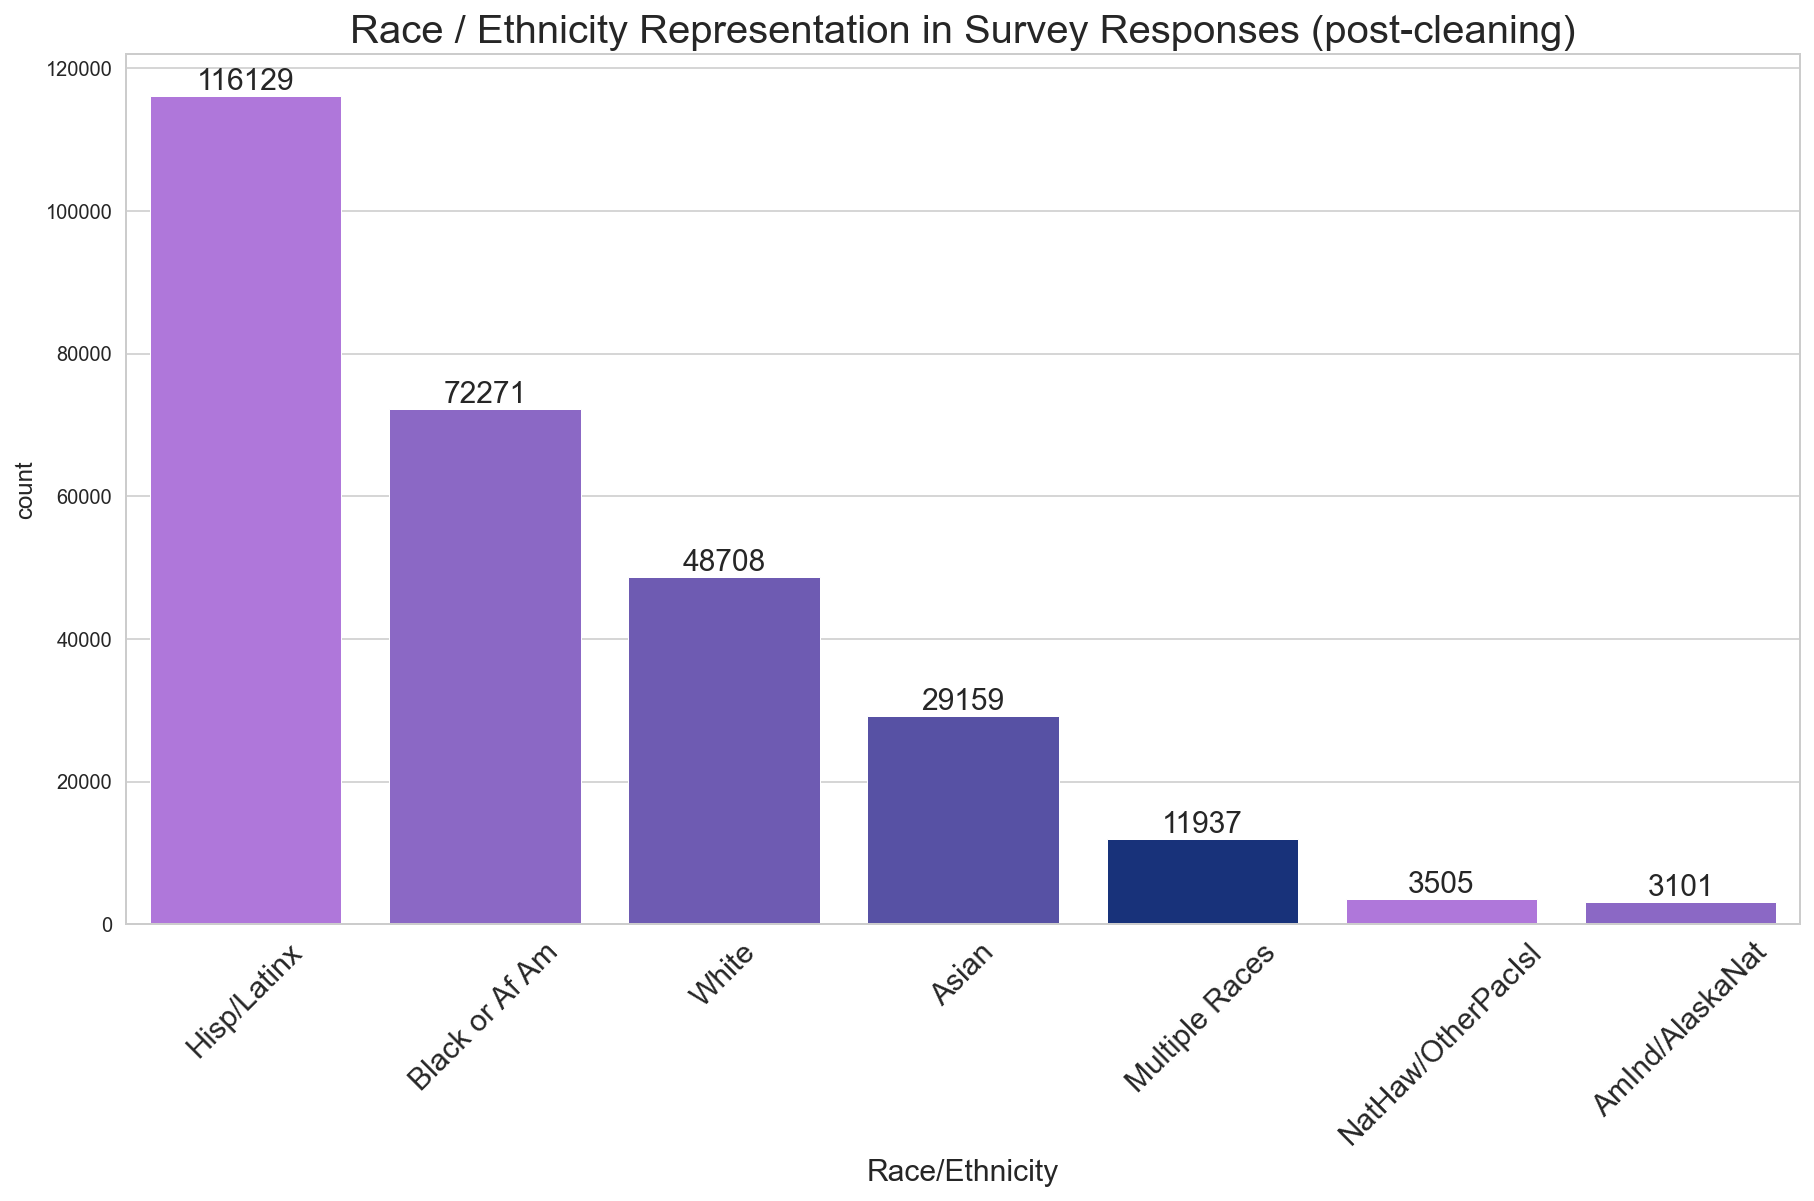

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df, x='race7', palette=colors, ax=ax, 
             order=df.race7.value_counts().index)
ax.set_xticklabels(labels=race7_labels, rotation=45, fontsize=15)
ax.set_title('Race / Ethnicity Representation in Survey Responses (post-cleaning)', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.set_xlabel('Race/Ethnicity', fontsize=15);

In [46]:
grade_labels = ['9th', '10th', '11th', '12th']

''

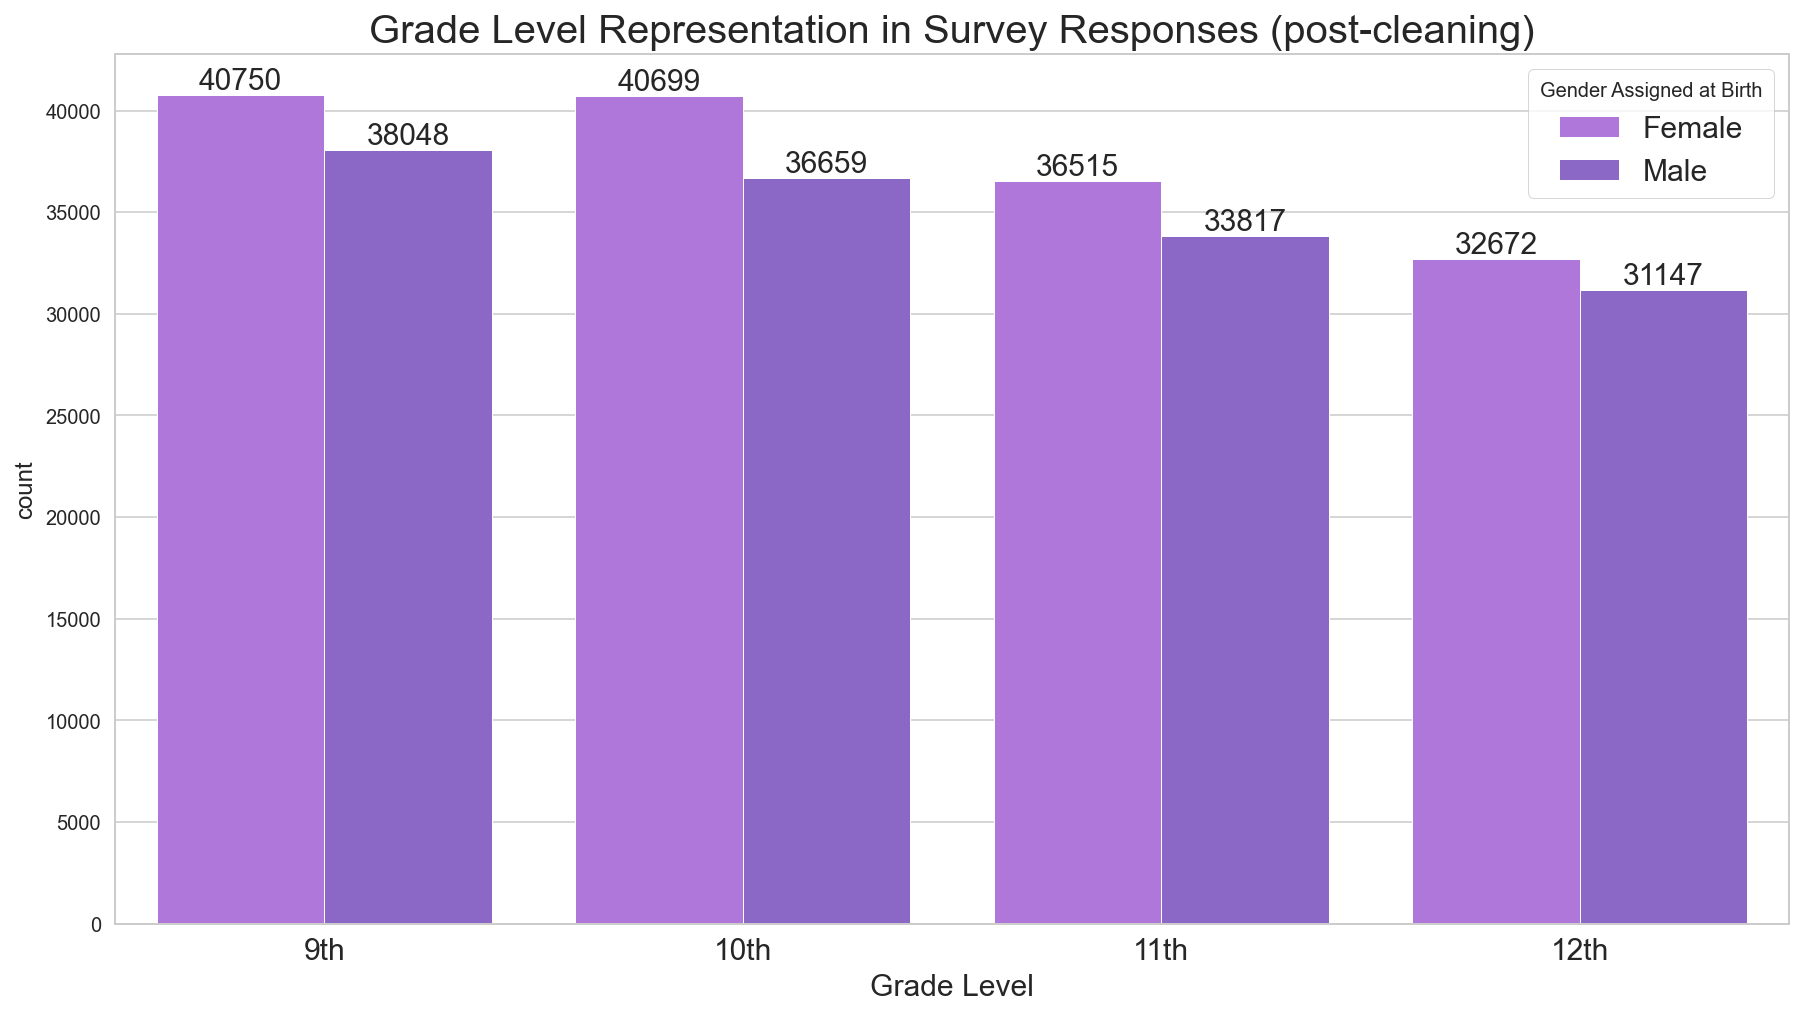

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df, x='grade', hue='sex', palette=colors, ax=ax)
ax.set_xticklabels(labels=grade_labels, fontsize=15)
ax.set_title('Grade Level Representation in Survey Responses (post-cleaning)', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=15, fmt='%d')

ax.set_xlabel('Grade Level', fontsize=15)
ax.legend(title='Gender Assigned at Birth', labels=['Female', 'Male'], loc='upper right', fontsize=15);
;

In [48]:
sex_dict = {1: 'Female', 2: 'Male'}
grade_dict = {1: '9th Grade', 2: '10th Grade', 3: '11th Grade', 
             4: '12th Grade'}

In [49]:
df.q58.unique()

array([nan,  2.,  1.])

In [50]:
df.q25.unique()

array([ 1.,  2., nan])

In [51]:
df.q30.unique()

array([ 1., nan,  2.])

In [52]:
# For each target, replace 2's (No's...) with 0s so that 1 (Yes) is the positive class

df.q58.replace(to_replace={2.: 0}, inplace=True)
df.q25.replace(to_replace={2.: 0}, inplace=True)
df.q30.replace(to_replace={2.: 0}, inplace=True)

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
enc = LabelEncoder()

In [57]:
enc.fit(df.sitename)

LabelEncoder()

In [64]:
df.sitename = enc.transform(df.sitename)

In [65]:
df.sitename.unique()

array([ 9,  8,  7, 11, 12,  6, 18, 20, 19, 21,  1,  2,  3,  4,  5, 24, 25,
       27, 30, 29, 32, 31, 10, 14, 23, 33,  0, 13, 16, 15, 17, 22, 28, 26,
       34])

In [68]:
sitename_dict = dict(zip(enc.classes_, enc.transform(enc.classes_)))
sitename_dict

{'Albuquerque, NM (AB)': 0,
 'Borough of Bronx, NY (NYG)': 1,
 'Borough of Brooklyn, NY (NYH)': 2,
 'Borough of Manhattan, NY (NYI)': 3,
 'Borough of Queens, NY (NYJ)': 4,
 'Borough of Staten Island, NY (NYK)': 5,
 'Broward County, FL (FT)': 6,
 'Charlotte-Mecklenburg County, NC (CM)': 7,
 'Chicago, IL (CH)': 8,
 'Clark County, NV (CC)': 9,
 'Cleveland, OH (CE)': 10,
 'Dallas, TX (DA)': 11,
 'Duval County, FL (DU)': 12,
 'Eaton Consortium, MI (EA)': 13,
 'Fort Worth, TX (FW)': 14,
 'Gaston County, NC (GS)': 15,
 'Genesee Consortium, MI (GE)': 16,
 'Hillsborough County, FL (HL)': 17,
 'Los Angeles, CA (LO)': 18,
 'Miami-Dade County, FL (MM)': 19,
 'Milwaukee, WI (ML)': 20,
 'New York City, NY (NYC)': 21,
 'Newark, NJ (NW)': 22,
 'Oakland, CA (OA)': 23,
 'Orange County, FL (OL)': 24,
 'Palm Beach County, FL (PB)': 25,
 'Pasco County, FL (PS)': 26,
 'Philadelphia, PA (PH)': 27,
 'Portland, OR (PO)': 28,
 'San Bernardino, CA (SB)': 29,
 'San Diego, CA (SA)': 30,
 'San Francisco, CA (SF)': 

In [69]:
df.dropna(axis=0, subset=['q58', 'q25', 'q30'], inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196861 entries, 208220 to 504248
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sitename  196861 non-null  int64  
 1   year      196861 non-null  int64  
 2   record    196861 non-null  int64  
 3   age       196430 non-null  float64
 4   sex       196168 non-null  float64
 5   grade     194947 non-null  float64
 6   race7     190929 non-null  float64
 7   bmi       179598 non-null  float64
 8   sexid2    166930 non-null  float64
 9   q25       196861 non-null  float64
 10  q30       196861 non-null  float64
 11  q58       196861 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 19.5 MB


In [71]:
from skmultilearn.model_selection import IterativeStratification


In [72]:
y = df[['q58', 'q25', 'q30']]
y.shape

(196861, 3)

In [73]:
X = df.drop(columns=['q58', 'q25', 'q30'])

In [74]:
X.shape, y.shape

((196861, 9), (196861, 3))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [76]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((157488, 9), (39373, 9), (157488, 3), (39373, 3))

In [77]:
y_train.head()

,q58,q25,q30
501792,1.0,0.0,1.0
466246,1.0,0.0,0.0
309771,1.0,1.0,1.0
501064,0.0,0.0,0.0
257232,0.0,0.0,0.0


In [78]:
y_train.q58.sum() / len(y_train) * 100, y_test.q58.sum() / len(y_test) * 100

(36.78692979782587, 36.786630432021944)

In [79]:
y_train.q25.sum() / len(y_train) * 100, y_test.q25.sum() / len(y_test) * 100

(29.960377933556842, 29.959616996418863)

In [80]:
y_train.q30.sum() / len(y_train) * 100, y_test.q30.sum() / len(y_test) * 100

(25.91054556537641, 25.911157392121503)

In [81]:
# Impute missing values in train set

In [82]:
from sklearn.impute import KNNImputer

In [84]:
imputer = KNNImputer(n_neighbors=3, weights='distance', metric='nan_euclidean')

In [85]:
imputer.fit(X_train)

KNNImputer(n_neighbors=3, weights='distance')

In [86]:
X_train = imputer.transform(X_train)

In [87]:
X_test = imputer.transform(X_test)

In [88]:
X_train.shape, X_test.shape

((157488, 9), (39373, 9))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Proportion of Classes for each Target, Full Dataset')

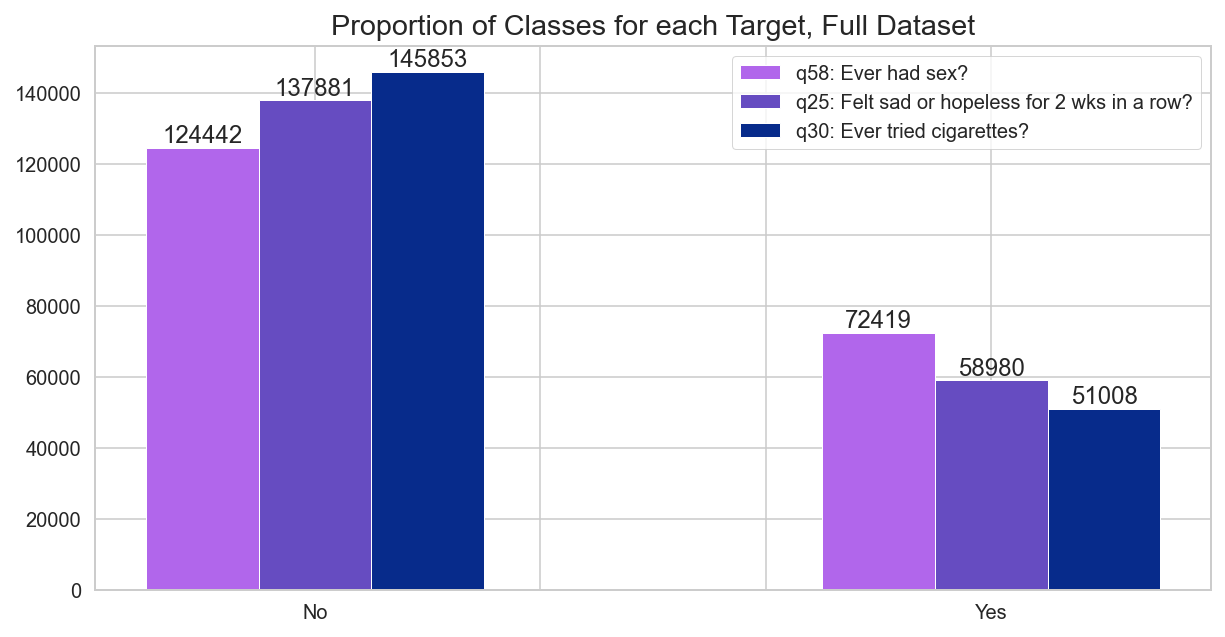

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))

d_heights, d_bins = np.histogram(y['q58'],bins=[0, .3, 1])
m_heights, m_bins = np.histogram(y['q25'], bins=d_bins)
s_heights, s_bins = np.histogram(y['q30'], bins=m_bins)



width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor=colors[0], label='q58: Ever had sex?')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor=colors[2], label = 'q25: Felt sad or hopeless for 2 wks in a row?')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor=colors[4], label='q30: Ever tried cigarettes?')

ax.bar_label(ax.containers[0], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[2], fontsize=12, fmt='%d')

ax.set_xticklabels(labels=['', 'No', '', '','Yes'])

ax.legend()
ax.set_title('Proportion of Classes for each Target, Full Dataset')

In [90]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [91]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [92]:
preds = rf.predict(X_test)

In [93]:
pred_probs = rf.predict_proba(X_test)
q58_probs = pred_probs[0]
q25_probs = pred_probs[1]
q30_probs = pred_probs[2]

In [94]:
scores = pd.DataFrame(columns = ['accuracy', 'precision', 
                                               'recall', 'f1'])

q58_acc = round(accuracy_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_prec = round(precision_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_rec = round(recall_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_f1 = round(f1_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)

q25_acc = round(accuracy_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_prec = round(precision_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_rec = round(recall_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_f1 = round(f1_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)

q30_acc = round(accuracy_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_prec = round(precision_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_rec = round(recall_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_f1 = round(f1_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)


In [95]:
scores = scores.append({'accuracy': q58_acc, 'precision': q58_prec, 
                        'recall': q58_rec, 'f1': q58_f1}, ignore_index=True)
scores = scores.append({'accuracy': q25_acc, 'precision': q25_prec, 
                        'recall': q25_rec, 'f1': q25_f1}, ignore_index=True)
scores = scores.append({'accuracy': q30_acc, 'precision': q30_prec, 
                        'recall': q30_rec, 'f1': q30_f1}, ignore_index=True)
scores.set_axis(['q58', 'q25', 'q30'], axis=0)

,accuracy,precision,recall,f1
q58,66.50,55.36,46.10,50.31
q25,67.60,43.29,26.22,32.66
q30,72.12,43.46,25.29,31.97


In [178]:
y_test.iloc[200], q58_probs[200]

(q58    0.0
 q25    0.0
 q30    0.0
 Name: 1628007, dtype: float64,
 array([0.93537872, 0.06462128]))

In [179]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [201]:
cf = multilabel_confusion_matrix(y_test, preds) 
# tn, fp, fn, tp
cf

array([[[22666,  2223],
        [ 3818, 10666]],

       [[26341,  1236],
        [ 5327,  6469]],

       [[27859,  1312],
        [ 3784,  6418]]])

In [202]:
list_58 = cf[0].ravel()
list_25 = cf[1].ravel()
list_30 = cf[2].ravel()


In [203]:
cf_df = pd.DataFrame(index=['q58', 'q25', 'q30'], columns=['True Negative', 'False Positive', 'False Negative', 'True Positive'], data = [list_58, list_25, list_45])

In [204]:
cf_df = cf_df.T

In [205]:
cf_df

,q58,q25,q30
True Negative,22666,26341,27876
False Positive,2223,1236,1295
False Negative,3818,5327,3777
True Positive,10666,6469,6425


In [557]:
3789 / 10544

0.3593512898330804

#### Experimenting with Algorithms

One Vs Rest Classifier

In [217]:
ovr = OneVsRestClassifier(LogisticRegression(solver='sag', n_jobs=-1, class_weight='balanced'))
ovr.fit(X_train, y_train)
ovr_pred = ovr.predict(X_test)
# Scores

print("Accuracy:", accuracy_score(y_test['q58'], ovr_pred[:, 0]))
print("Precision:", precision_score(y_test['q58'], ovr_pred[:, 0]))
print("Recall:", recall_score(y_test['q58'], ovr_pred[:, 0]))
print("F1:", f1_score(y_test['q58'], ovr_pred[:, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test['q25'], ovr_pred[:, 1]))
print("Precision:", precision_score(y_test['q25'], ovr_pred[:, 1]))
print("Recall:", recall_score(y_test['q25'], ovr_pred[:, 1]))
print("F1:", f1_score(y_test['q25'], ovr_pred[:, 1]))
print('\n')
print("Accuracy:", accuracy_score(y_test['q30'], ovr_pred[:, 2]))
print("Precision:", precision_score(y_test['q30'], ovr_pred[:, 2]))
print("Recall:", recall_score(y_test['q30'], ovr_pred[:, 2]))
print("F1:", f1_score(y_test['q30'], ovr_pred[:, 2]))


MultiLabel KNN

In [251]:
X_train_lil = lil_matrix(X_train).toarray()
y_train_lil = lil_matrix(y_train).toarray()
X_test_lil = lil_matrix(X_test).toarray()


In [252]:
mlknn = MLkNN(k=10)
mlknn.fit(X_train_lil, y_train_lil)
mlknn_preds = mlknn.predict(X_test_lil)

mlknn_preds = mlknn_preds.todense()

# q58 scores

In [255]:
print("Accuracy q58:", accuracy_score(y_test['q58'], mlknn_preds[:, 0]))
print("Precision q58:", precision_score(y_test['q58'], mlknn_preds[:, 0]))
print("Recall q58:", recall_score(y_test['q58'], mlknn_preds[:, 0]))
print("F1 q58:", f1_score(y_test['q58'], mlknn_preds[:, 0]))
print('\n')
# q25 scores
print("Accuracy q25:", accuracy_score(y_test['q25'], mlknn_preds[:, 1]))
print("Precision q25:", precision_score(y_test['q25'], mlknn_preds[:, 1]))
print("Recall q25:", recall_score(y_test['q25'], mlknn_preds[:, 1]))
print("F1 q25:", f1_score(y_test['q25'], mlknn_preds[:, 1]))
print('\n')

# q45 scores
print("Accuracy q30:", accuracy_score(y_test['q30'], mlknn_preds[:, 2]))
print("Precision q30:", precision_score(y_test['q30'], mlknn_preds[:, 2]))
print("Recall q30:", recall_score(y_test['q30'], mlknn_preds[:, 2]))
print("F1 q30:", f1_score(y_test['q30'], mlknn_preds[:, 2]))

Accuracy q58: 0.7274528230005334
Precision q58: 0.6520048602673147
Recall q58: 0.5557166528583264
F1 q58: 0.6000223638600023


Accuracy q25: 0.6997688771493156
Precision q25: 0.498028702097461
Recall q25: 0.26771787046456424
F1 q25: 0.3482384076749187


Accuracy q30: 0.7805094861961243
Precision q30: 0.618361153262519
Recall q30: 0.39943148402274065
F1 q30: 0.4853501667460695


Binary Relevance kNN

In [261]:
brknna = BRkNNaClassifier()
brknna.fit(X_train_lil, y_train_lil)
brknna_pred = brknna.predict(X_test_lil)

# Scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [267]:
brknna_pred
# brknna_pred = brknna_pred.todense()


matrix([[0, 1, 0],
        [1, 0, 1],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int64)

In [268]:
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknna_pred[:, 0]))
print("Precision:", precision_score(y_test_array[:, 0], brknna_pred[:, 0]))
print("Recall:", recall_score(y_test_array[:, 0], brknna_pred[:, 0]))
print("F1:", f1_score(y_test_array[:, 0], brknna_pred[:, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknna_pred[:, 1]))
print("Precision:", precision_score(y_test_array[:, 0], brknna_pred[:, 1]))
print("Recall:", recall_score(y_test_array[:, 0], brknna_pred[:, 1]))
print("F1:", f1_score(y_test_array[:, 0], brknna_pred[:, 1]))
print('\n')
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknna_pred[:, 2]))
print("Precision:", precision_score(y_test_array[:, 0], brknna_pred[:, 2]))
print("Recall:", recall_score(y_test_array[:, 0], brknna_pred[:, 2]))
print("F1:", f1_score(y_test_array[:, 0], brknna_pred[:, 2]))

Accuracy: 0.726894064460417
Precision: 0.7096302955388246
Recall: 0.4359983429991715
F1: 0.5401359962365821


Accuracy: 0.635105275188581
Precision: 0.5188648822960336
Recall: 0.11108809721071528
F1: 0.1829968723343759


Accuracy: 0.686485662763823
Precision: 0.7417532760957976
Recall: 0.22666390499861916
F1: 0.34722369116869384


In [269]:
brknnb = BRkNNbClassifier()
brknnb.fit(X_train_lil, y_train_lil)
brknnb_pred = brknnb.predict(X_test_lil)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [272]:
brknnb_pred = brknnb_pred.todense()


In [273]:
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknnb_pred[:, 0]))
print("Precision:", precision_score(y_test_array[:, 0], brknnb_pred[:, 0]))
print("Recall:", recall_score(y_test_array[:, 0], brknnb_pred[:, 0]))
print("F1:", f1_score(y_test_array[:, 0], brknnb_pred[:, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknnb_pred[:, 1]))
print("Precision:", precision_score(y_test_array[:, 0], brknnb_pred[:, 1]))
print("Recall:", recall_score(y_test_array[:, 0], brknnb_pred[:, 1]))
print("F1:", f1_score(y_test_array[:, 0], brknnb_pred[:, 1]))
print('\n')
print("Accuracy:", accuracy_score(y_test_array[:, 0], brknnb_pred[:, 2]))
print("Precision:", precision_score(y_test_array[:, 0], brknnb_pred[:, 2]))
print("Recall:", recall_score(y_test_array[:, 0], brknnb_pred[:, 2]))
print("F1:", f1_score(y_test_array[:, 0], brknnb_pred[:, 2]))

Accuracy: 0.42099916186218983
Precision: 0.3461296412838263
Recall: 0.6455399061032864
F1: 0.4506349856616141


Accuracy: 0.4048967566606558
Precision: 0.22164146599464873
Recall: 0.2459265396299365
F1: 0.23315333006054656


Accuracy: 0.3954232595941381
Precision: 0.34836652349342706
Recall: 0.7391604529135598
F1: 0.47354918612880403


In [294]:
clf = BinaryRelevance(classifier=RandomForestClassifier(class_weight='balanced', random_state=42), 
                     require_dense = [False, True])
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

In [298]:
br_rf_acc = accuracy_score(y_test, y_hat)
br_rf_prec = precision_score(y_test, y_hat, average='micro')
br_rf_recall = recall_score(y_test, y_hat, average='micro')
br_rf_f1 = f1_score(y_test, y_hat, average='micro')

br_rf_hamm = hamming_loss(y_test, y_hat)

In [299]:
br_rf_acc, br_rf_prec, br_rf_recall, br_rf_f1, br_rf_hamm

(0.6655322175094608,
 0.8412238091785689,
 0.6360945123622609,
 0.7244178060810389,
 0.1494763755196031)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Proportion of Classes for each Target, Test Set')

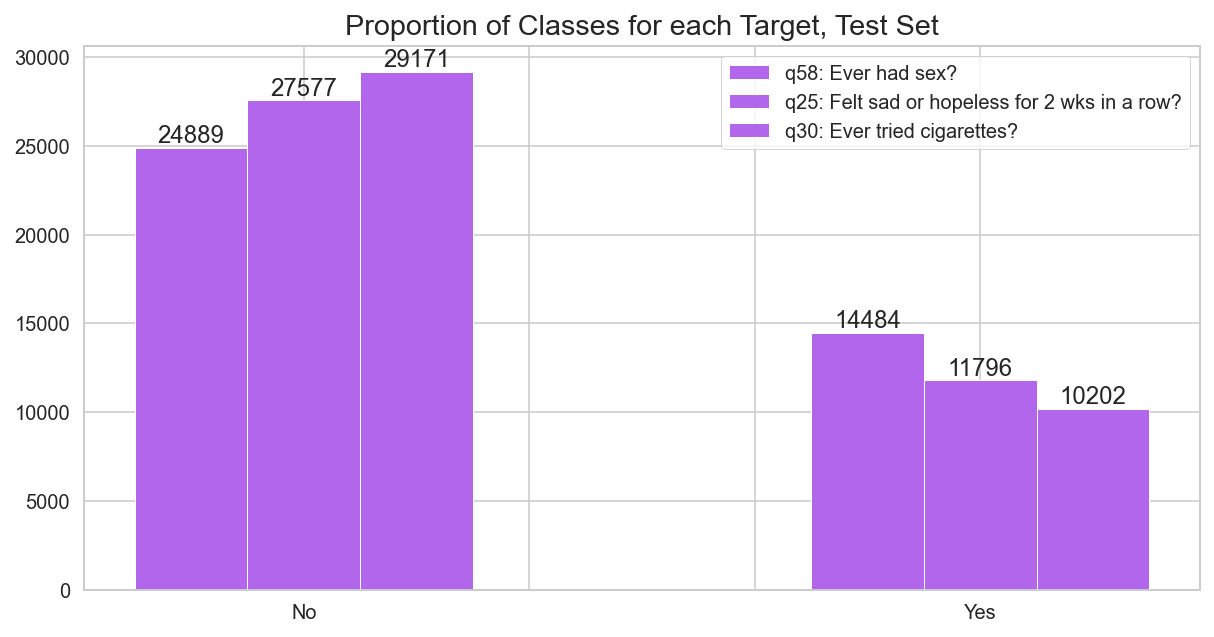

In [301]:
fig, ax = plt.subplots(figsize=(10, 5))

d_heights, d_bins = np.histogram(y_test['q58'],bins=[0, .3, 1])
m_heights, m_bins = np.histogram(y_test['q25'], bins=d_bins)
s_heights, s_bins = np.histogram(y_test['q30'], bins=m_bins)
sns.set_style('white')


width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor=colors[0], label='q58: Ever had sex?')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor=colors[0], label = 'q25: Felt sad or hopeless for 2 wks in a row?')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor=colors[0], label='q30: Ever tried cigarettes?')

ax.bar_label(ax.containers[0], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[2], fontsize=12, fmt='%d')

ax.set_xticklabels(labels=['', 'No', '', '','Yes'])

ax.legend()
ax.set_title('Proportion of Classes for each Target, Test Set')

In [584]:
X_train_trans.shape, X_test_trans.shape, y_train.shape, y_test.shape

((117021, 21), (29256, 21), (117021, 3), (29256, 3))

In [218]:
categories = list(y_test.columns.values)
categories

['q58', 'q25', 'q30']

In [614]:
hamming_loss(y_test, mlknn_preds)

0.2938542521192234

In [313]:
from sklearn.model_selection import GridSearchCV

In [314]:
param_grid = {'n_estimators': [150, 200, 250], 'criterion': ['gini', 'entropy'], 
             'max_depth': [15, 20, 25], 'max_features': [5, 10, 21]}

In [315]:
grid_rf = GridSearchCV(rf, param_grid)


In [316]:
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 25], 'max_features': [5, 10, 21],
                         'n_estimators': [150, 200, 250]})

In [317]:
grid_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features=5, n_estimators=250,
                       random_state=42)

In [320]:
rf_hyp = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features=5, n_estimators=250,
                       random_state=42)

In [321]:
rf_hyp.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features=5, n_estimators=250,
                       random_state=42)

In [ ]:
pred_proba = rf_hyp.predict_proba()

In [322]:
preds = rf_hyp.predict(X_test)

In [323]:
rf_hyp_hamm = hamming_loss(y_test, preds)
# q58 scores
print("Accuracy q58:", accuracy_score(y_test['q58'], preds[:, 0]))
print("Precision q58:", precision_score(y_test['q58'], preds[:, 0]))
print("Recall q58:", recall_score(y_test['q58'], preds[:, 0]))
print("F1 q58:", f1_score(y_test['q58'], preds[:, 0]))
print('\n')
# q25 scores
print("Accuracy q25:", accuracy_score(y_test['q25'], preds[:, 1]))
print("Precision q25:", precision_score(y_test['q25'], preds[:, 1]))
print("Recall q25:", recall_score(y_test['q25'], preds[:, 1]))
print("F1 q25:", f1_score(y_test['q25'], preds[:, 1]))
print('\n')

# q30 scores
print("Accuracy q30:", accuracy_score(y_test['q30'], preds[:, 2]))
print("Precision q30:", precision_score(y_test['q30'], preds[:, 2]))
print("Recall q30:", recall_score(y_test['q30'], preds[:, 2]))
print("F1 q30:", f1_score(y_test['q30'], preds[:, 2]))
print('\n')

print('Hamming Loss: ', rf_hyp_hamm)

Accuracy q58: 0.846189012775252
Precision q58: 0.8177499622982959
Recall q58: 0.7487572493786246
F1 q58: 0.7817343040438262


Accuracy q25: 0.8322962436187235
Precision q25: 0.8386591887309247
Recall q25: 0.5451000339097999
F1 q25: 0.6607408929764168


Accuracy q30: 0.8711807583877277
Precision q30: 0.821106659989985
Recall q30: 0.6429131542834738
F1 q30: 0.7211654755360087


Hamming Loss:  0.15011132840609892


In [333]:
y_train.shape

(157488, 3)

In [324]:
scores = pd.DataFrame(columns = ['accuracy', 'precision', 
                                               'recall', 'f1'])

q58_acc = round(accuracy_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_prec = round(precision_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_rec = round(recall_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)
q58_f1 = round(f1_score(y_test.iloc[:, 0], preds[:, 0]) *100, 2)

q25_acc = round(accuracy_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_prec = round(precision_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_rec = round(recall_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)
q25_f1 = round(f1_score(y_test.iloc[:, 1], preds[:, 1]) *100, 2)

q30_acc = round(accuracy_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_prec = round(precision_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_rec = round(recall_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)
q30_f1 = round(f1_score(y_test.iloc[:, 2], preds[:, 2]) *100, 2)


In [325]:
scores = scores.append({'accuracy': q58_acc, 'precision': q58_prec, 
                        'recall': q58_rec, 'f1': q58_f1}, ignore_index=True)
scores = scores.append({'accuracy': q25_acc, 'precision': q25_prec, 
                        'recall': q25_rec, 'f1': q25_f1}, ignore_index=True)
scores = scores.append({'accuracy': q30_acc, 'precision': q30_prec, 
                        'recall': q30_rec, 'f1': q30_f1}, ignore_index=True)
scores.set_axis(['q58', 'q25', 'q30'], axis=0)

,accuracy,precision,recall,f1
q58,84.62,81.77,74.88,78.17
q25,83.23,83.87,54.51,66.07
q30,87.12,82.11,64.29,72.12


In [327]:
cf = multilabel_confusion_matrix(y_test, preds) 
cf
# tn, fp, fn, tp


array([[[22472,  2417],
        [ 3639, 10845]],

       [[26340,  1237],
        [ 5366,  6430]],

       [[27742,  1429],
        [ 3643,  6559]]])

In [339]:
3643 /10202

0.35708684571652616

In [340]:
pred_probs = rf_hyp.predict_proba(X_test)
q58_probs = pred_probs[0]
q25_probs = pred_probs[1]
q30_probs = pred_probs[2]

In [370]:
cols = ['year',
 'age',
 'sex',
 'grade',
 'race7',
 'bmi',
 'sexid2',
 'q12',
 'q15',
 'q17',
 'q23',
 'q24',
 'q41',
 'q45',
 'q67',
 'q77',
 'q78',
 'q79',
 'q80',
 'q82',
 'q87',
 'q88']

In [359]:
sample = [[2019, 4, 2, 2, 4, 22.8, 1, 1, 1, 1, 2, 2, 1, 1, 3, 8, 8, 1, 3, 2, 2, 3]]

In [362]:
rf_hyp.predict_proba(sample)

[array([[0.88411114, 0.11588886]]),
 array([[0.91576038, 0.08423962]]),
 array([[0.96490711, 0.03509289]])]

In [378]:
samp = [[2019, 3, 2, 2, 2, 22, 2, 1, 1, 1, 2, 2, 1, 1, 3, 8, 8, 1, 3, 2, 2, 3]]

In [379]:
rf_hyp.predict(samp)

array([[0., 0., 0.]])

In [371]:
df_feature_importances = pd.DataFrame(rf_hyp.feature_importances_*100,columns=["Importance"],index=cols)


In [374]:
df_feature_importances.sort_values(by='Importance')

,Importance
q23,1.286616
q15,1.364896
sex,1.570273
q12,1.682945
q24,1.852842
sexid2,2.230936
grade,2.865485
q87,3.009012
q17,3.328290
age,3.701224


In [363]:
import joblib

In [364]:
filename = 'rf_hyp.sav'
joblib.dump(rf_hyp, filename)

['rf_hyp.sav']

### Tried Scaling; did not improve scores

In [192]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [195]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
pipe.fit(X_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rf', RandomForestClassifier())])

pipe.score(X_test, y_test)

0.6660655779341172

In [196]:
preds = pipe.predict(X_test)

In [197]:
print("Accuracy q58:", accuracy_score(y_test['q58'], preds[:, 0]))
print("Precision q58:", precision_score(y_test['q58'], preds[:, 0]))
print("Recall q58:", recall_score(y_test['q58'], preds[:, 0]))
print("F1 q58:", f1_score(y_test['q58'], preds[:, 0]))

# q25 scores
print("Accuracy q25:", accuracy_score(y_test['q25'], preds[:, 1]))
print("Precision q25:", precision_score(y_test['q25'], preds[:, 1]))
print("Recall q25:", recall_score(y_test['q25'], preds[:, 1]))
print("F1 q25:", f1_score(y_test['q25'], preds[:, 1]))

# q45 scores
print("Accuracy q30:", accuracy_score(y_test['q30'], preds[:, 2]))
print("Precision q30:", precision_score(y_test['q30'], preds[:, 2]))
print("Recall q30:", recall_score(y_test['q30'], preds[:, 2]))
print("F1 q30:", f1_score(y_test['q30'], preds[:, 2]))

Accuracy q58: 0.8465699845071496
Precision q58: 0.8275273489021646
Recall q58: 0.7363987848660591
F1 q58: 0.7793080773024512
Accuracy q25: 0.8333121682371168
Precision q25: 0.8395846852693056
Recall q25: 0.5484062394031876
F1 q25: 0.6634531562483976
Accuracy q30: 0.8705712036166916
Precision q30: 0.8302716688227685
Recall q30: 0.6290923348363066
F1 q30: 0.7158153022529555


In [199]:
scores

,accuracy,precision,recall,f1
0,84.74,82.95,73.65,78.02
1,83.41,85.40,53.82,66.03
2,87.12,83.23,62.98,71.70


In [ ]:
# Try a Label Power Set with Classifier chain and Random forest: 
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 20, 50],
    },
]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)


In [388]:
def predict(age, sex, race7, bmi, grade, sexid2): 
    year = 2019
    age = age_dict.get(age)
    sex = sex_dict.get(sex)
    race7 = race7_dict.get(race7)
    bmi = bmi_dict.get(bmi)
    grade = grade_dict.get(grade)
    sexid2 = sexid2_dict.get(sexid2)
    sample = [[year, age, sex, grade, race7, bmi, sexid2, 1, 1, 1, 2, 2, 1, 1, 3, 8, 8, 1, 3, 2, 2, 3]]
    model = rf_hyp
    y_pred = model.predict(sample)
    # y_pred_proba = model.predict_proba(sample)
    # results = y_pred, y_pred_proba
    return f'{y_pred}'

In [389]:
age_dict = {'12 yrs -': 1, '13 yrs': 2, '14 yrs': 3, 
           '15 yrs': 4, '16 yrs': 5, '17 yrs': 6, '18 yrs +': 7}
sex = ['Female', 'Male']
sex_dict = {'Female': 1, 'Male': 2}
race7 = ['Hisp/Latinx', 'Black or Af Am', 
               'White', 'Asian', 'Multiple Races', 
               'NatHaw/OtherPacIsl', 'AmInd/AlaskaNat']
race7_dict = {'AmInd/AlaskaNat': 1, 'Asian': 2, 'Black or Af Am': 3, 
             'Hisp/Latinx': 4, 'NatHaw/OtherPacIsl': 5, 'White': 6, 'Multiple Races (Non-Hisp)': 7}
bmi = ['Below 18.5', '18.5-24.9', '25.0-29.9', '30.0 and Above']
bmi_dict = {'Below 18.5': 18.5, '18.5-24.9': 20, '25.0-29.9': 27.5, '30.0 and Above': 30}
grade = ['9th', '10th', '11th', '12th']
grade_dict = {'9th Grade': 1, '10th Grade': 2, '11th Grade': 3, 
             '12th Grade': 4}
sexid2 = ['Heterosexual', 'Sexual Minority', 'Unsure']
sexid2_dict = {'Heterosexual': 1, 'Sexual Minority': 2, 'Unsure': 3}

In [392]:
year = 2019
age = '12 yrs -'
sex = 'Female'
race7 = 'Hisp/Latinx'
bmi = '18.5-24.9'
grade = '9th Grade'
sexid2 = 'Heterosexual'

In [393]:
predict(age, sex, race7, bmi, grade, sexid2)

'[[0. 0. 0.]]'